# Advanced Scientific Data Format (ASDF)

ASDF is a next-generation interchange format for scientific data. The *asdf* package contains the Python implementation of the ASDF Standard.

The ASDF format has the following features:

- A hierarchical, human-readable metadata format (implemented using YAML)
- Numerical arrays are stored as binary data blocks which can be memory mapped.
  Data blocks can optionally be compressed.
- The structure of the data can be automatically validated using schemas (implemented using JSON Schema)
- Native Python data types (numerical types, strings, dicts, lists) are serialized automatically
- ASDF can be extended to serialize custom data types

In [2]:
import asdf
from asdf import AsdfFile

# Save "Hello World!" to a file
f = AsdfFile()
f.tree['Hello'] = 'World!'
f.write_to('hw.asdf')

In [ ]:
# The top of the file has software and version information
! less hw.asdf

#ASDF 1.0.0
#ASDF_STANDARD 1.3.0
%YAML 1.1
%TAG ! tag:stsci.edu:asdf/
--- !core/asdf-1.1.0
asdf_library: !core/software-1.0.0 {author: Space Telescope Science Institute, h omepage: 'http://github.com/spacetelescope/asdf',
  name: asdf, version: 2.2.0.dev1597}
history:
  extensions:
  - !core/extension_metadata-1.0.0
    extension_class: asdf.extension.BuiltinExtension
    software: {name: asdf, version: 2.2.0.dev1597}
Hello: World!
...
hw.asdf (END)

In [3]:
# Read back the file
# Every ASDF file object has an attribute "tree" which is a dict
fa = asdf.open('hw.asdf')
fa.tree

{'asdf_library': {'author': 'Space Telescope Science Institute',
  'homepage': 'http://github.com/spacetelescope/asdf',
  'name': 'asdf',
  'version': '2.2.0.dev1606'},
 'history': {'extensions': [<asdf.tags.core.ExtensionMetadata at 0xb16f64c18>]},
 'Hello': 'World!'}

In [4]:
# Save an array to file
import numpy as np

data = np.random.random((3,4))
tree = {'data': data}
f = AsdfFile(tree)
f.write_to('data.asdf')

In [ ]:
# The array is saved inline at the end of the file
# It's possible to save the binary block in compressed form
!less data.asdf

#ASDF 1.0.0
#ASDF_STANDARD 1.3.0
%YAML 1.1
%TAG ! tag:stsci.edu:asdf/
--- !core/asdf-1.1.0
asdf_library: !core/software-1.0.0 {author: Space Telescope Science Institute, h omepage: 'http://github.com/spacetelescope/asdf',
  name: asdf, version: 2.2.0.dev1597}
history:
  extensions:
  - !core/extension_metadata-1.0.0
    extension_class: asdf.extension.BuiltinExtension
    software: {name: asdf, version: 2.2.0.dev1597}
data: !core/ndarray-1.0.0
  data:
  - [0.5031667342111454, 0.3300611516837403, 0.34983198596992926, 0.752043618526 256]
  - [0.2849795746255557, 0.6074089816411002, 0.11315713727964893, 0.947788378717 7395]
  - [0.9650990967420865, 0.5671246939783094, 0.8266169788506081, 0.8957743510922 547]
  datatype: float64
  shape: [3, 4]
data.asdf

To save the array as a binary block pass `all_array_storage="internal"`. 
It's possible to save the binary block in compressed form.

In [5]:
f.write_to('data_binary.asdf', all_array_storage='internal')

In [ ]:
!less data_binary.asdf

#ASDF 1.0.0
#ASDF_STANDARD 1.3.0
%YAML 1.1
%TAG ! tag:stsci.edu:asdf/
--- !core/asdf-1.1.0
asdf_library: !core/software-1.0.0 {author: Space Telescope Science Institute, h omepage: 'http://github.com/spacetelescope/asdf',
  name: asdf, version: 2.2.0.dev1606}
history:
  extensions:
  - !core/extension_metadata-1.0.0
    extension_class: asdf.extension.BuiltinExtension
    software: {name: asdf, version: 2.2.0.dev1606}
data: !core/ndarray-1.0.0
  source: 0
  datatype: float64
  byteorder: little
  shape: [3, 4]
...
<D3>BLK^@0^@^@^@^@^@^@^@^@^@^@^@^@^@^@^@`^@^@^@^@^@^@^@`^@^@^@^@^@^@^@`<8F>b^LN? <8E><FB><C2>ӭ<AC>3+=<CC>-|^Q<8C><F6>C^U<ED>?<EC>}^W<EC>r4<EC>?H<8D>'<E3><CE>^@
<E5>?<98>ē<D7>^_R<C5>?<AA>Æ^Tm<92><D1>?_<9B>JUX<E5><E1>?<B0><89>0M^Mu<B9>?`<F1>
<AB><AC>^K<A9><AC>?<F0>Q<A3>S<B7><90><AC>?<U+009A>^MЙ<99><E7>?<94><9D><D2>E^S
data_binary.asdf

In [6]:
# Many astropy objects can already be serialized to file
# Example saving an astropy compound model
from astropy.modeling.models import Rotation2D, Polynomial2D, Mapping


model = (Mapping((0, 1, 0, 1)) | 
         Polynomial2D(1, c0_0=1) & Polynomial2D(1, c0_0=2) |
         Rotation2D(23.5))

f = AsdfFile()
f.tree['model'] = model
f.write_to('model.asdf')

In [7]:
# Reading it back reconstructs the model and it can be evaluated directly.
fa = asdf.open('model.asdf')
new_model = fa.tree['model']
new_model(1, 1)

(0.11956193653463165, 2.2328692176954945)

The primary motivation for ASDF was serializing complex WCS objects and transforms which can't be described by the FITS WCS or written to FITS files.

# Generalized World Coordinate System (GWCS) 

**Imaging example**

In [8]:
import numpy as np
from astropy.modeling.models import (Shift, Scale, Rotation2D,
               Pix2Sky_TAN, RotateNative2Celestial, Mapping, 
               Polynomial2D, Multiply)
from astropy import coordinates as coord
from astropy import units as u
from gwcs import wcs
from gwcs import coordinate_frames as cf

In [9]:
# Create two coordinate frames.
detector_frame = cf.Frame2D(name="detector", axes_names=("x", "y"),
                            unit=(u.pix, u.pix))
sky_frame = cf.CelestialFrame(reference_frame=coord.ICRS(),
                              name='icrs')

In [10]:
# Create the transform between them
det2sky = (Shift(-10.5*u.pix) & Shift(-13.2 * u.pix) | 
           Rotation2D(0.0023 * u.arcsec) | 
           Multiply(.01*u.deg/u.pix) & Multiply(.04*u.deg/u.pix) | Pix2Sky_TAN() |     
           RotateNative2Celestial(5.6*u.deg, -72.05*u.deg, 180*u.deg))

In [11]:
# A WCS pipeline is a list of steps, represented as tuples (frame, transform_to_next_frame)
pipeline = [(detector_frame, det2sky),
            (sky_frame, None)]
wcsobj = wcs.WCS(pipeline)

In [12]:
# Since the above WCS was initialized with Quantities, the inputs must be also Quantities.
ra, dec = wcsobj(100*u.pix, 200*u.pix)
print(ra, dec)

7.669659040444465 deg -64.60544996751645 deg


In [13]:
# Write the WCS to an asdf file
f = AsdfFile()
f.tree['wcs'] = wcsobj
f.write_to('wcs.asdf')

In [16]:
# Read it back and evaluate it
fa = asdf.open('wcs.asdf')
fa.tree['wcs'](100*u.pix, 200*u.pix)

(<Quantity 7.66965904 deg>, <Quantity -64.60544997 deg>)

In [17]:
# The complex WCS object can be written to a FITS file.
# It is added as a separate extension.
from astropy.io import fits
hdulist = fits.open('image.fits')
tree = {'sci': hdulist[1].data, 'wcs': wcsobj}
# The tree contains references to the FITS hdu data.

In [18]:
# Now save it to a FITS file using AsdfInFits 
from asdf import fits_embed
ff = fits_embed.AsdfInFits(hdulist, tree)
ff.write_to('embedded_asdf.fits', overwrite=True)

In [19]:
# Open the FITS file using astropy.fits
ef = fits.open('embedded_asdf.fits')
ef.info()

Filename: embedded_asdf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     212   ()      
  1  SCI           1 ImageHDU        18   (2048, 2048)   float32   
  2  ASDF          1 BinTableHDU     11   1R x 1C   [2865B]   


In [20]:
# FITs does not understand the ASDF extension.
# To use it open it with asdf
efa = asdf.open('embedded_asdf.fits')
efa.tree.keys()

dict_keys(['asdf_library', 'history', 'sci', 'wcs'])

In [21]:
efa['wcs'](100*u.pix, 200*u.pix)

(<Quantity 7.66965904 deg>, <Quantity -64.60544997 deg>)

In [23]:
#The data is also in the ASDF file
from matplotlib import pyplot as plt
%matplotlib inline
data = efa.tree['sci']

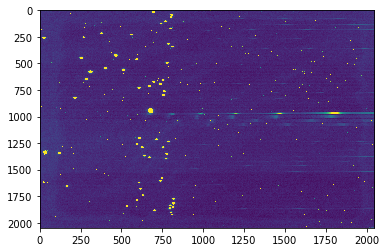

In [41]:
plt.imshow(efa.tree['sci'].data, aspect='auto')

 Github:   https://github.com/spacetelescope/asdf
 
 Docs:     http://asdf.readthedocs.io/en/latest/index.html